In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

%cd 'gdrive/My Drive/licenta/car_model_classification'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/licenta/car_model_classification


In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
import os
import json
 
from torchvision import models, transforms

In [0]:
class NetworkGradCam(nn.Module):
    def __init__(self, feature_extractor, num_classes, feature_extract):
        super().__init__()

        # gradient placeholder
        self.gradient = None

        if hasattr(feature_extractor, 'fc'): # resnets
            # isolate the feature blocks
            self.features = nn.Sequential(feature_extractor.conv1,
                                          feature_extractor.bn1,
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                          feature_extractor.layer1, 
                                          feature_extractor.layer2, 
                                          feature_extractor.layer3, 
                                          feature_extractor.layer4)
            # average pooling layer
            self.avgpool = feature_extractor.avgpool

            in_features = feature_extractor.fc.in_features
            
            # classifier
            self.classifier = nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
            
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)

    def forward(self, x):
        # extract the features
        x = self.features(x)
        
        # complete the forward pass
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

In [0]:
def construct_model(config, num_classes):
    if config['arch'] == 'resnext50':
        feature_extractor = models.resnext50_32x4d(pretrained=config['pretrained'])
    elif config['arch'] == 'resnet18':
        feature_extractor = models.resnet18(pretrained=config['pretrained'])
    elif config['arch'] == 'resnet34':
        feature_extractor = models.resnet34(pretrained=config['pretrained'])
    elif config['arch'] == 'resnet50':
        feature_extractor = models.resnet50(pretrained=config['pretrained'])
    elif config['arch'] == 'mobilenetv2':
        feature_extractor = models.mobilenet_v2(pretrained=config['pretrained'])
    elif config['arch'] == 'se_resnet50':
        feature_extractor = se_resnet50(pretrained=config['pretrained'])
    elif config['arch'] == 'se_linear_resnet34':
        feature_extractor = se_linear_resnet34(pretrained=config['pretrained'])
    elif config['arch'] == 'se_linear_resnet50':
        feature_extractor = se_linear_resnet50(pretrained=config['pretrained'])
    elif config['arch'] == 'cbam_resnet50':
        feature_extractor = cbam_resnet50(pretrained=config['pretrained'])
    elif config['arch'] == 'cbam_linear_resnet34':
        feature_extractor = cbam_linear_resnet34(pretrained=config['pretrained'])
    elif config['arch'] == 'cbam_linear_resnet50':
        feature_extractor = cbam_linear_resnet50(pretrained=config['pretrained'])
    else:
        print("Invalid model name, exiting...")
        exit()

    if config['grad_cam']:
        model = NetworkGradCam(feature_extractor, num_classes, config['feature_extract'])
    
    # model = feature_extractor

    return model

In [0]:
def load_weight(model, path, device):
    sd = torch.load(os.path.join(path, 'best.pth'), map_location=device)
    model.load_state_dict(sd['model'])
    epoch = sd['epoch']

    print('Loaded model from epoch %d\n' % (epoch))

In [0]:
# def main(args):
#     device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#     model_path = args.path
#     model_name = model_path.split('/')[-2]
#     with open(os.path.join(model_path, 'config.json')) as json_file:
#         config = json.load(json_file)
 
#     model = construct_model(config, num_classes=157)
#     load_weight(model, model_path, device)
#     model.to(device)
#     print(model)

#     save_dir_filters = os.path.join('outputs_filters', model_name)
#     save_dir_features = os.path.join('outputs_feature_visualizations', model_name)
#     os.makedirs(save_dir_filters, exist_ok=True)
#     os.makedirs(save_dir_features, exist_ok=True)
    
#     model_weights = [] # we will save the conv layer weights in this list
#     conv_layers = [] # we will save the x conv layers in this list
    
#     # get all the model children as list
#     model_children = list(model.features.children())

#     # counter to keep count of the conv layers
#     counter = 0 
    
#     # append all the conv layers and their respective weights to the list
#     for i in range(len(model_children)):
#         if type(model_children[i]) == nn.Conv2d:
#             counter += 1
#             model_weights.append(model_children[i].weight)
#             conv_layers.append(model_children[i])
#         elif type(model_children[i]) == nn.Sequential:
#             for j in range(len(model_children[i])):
#                 for child in model_children[i][j].children():
#                     if type(child) == nn.Conv2d:
#                         counter += 1
#                         model_weights.append(child.weight)
#                         conv_layers.append(child)
#     print(f"Total convolutional layers: {counter}")

#     # take a look at the conv layers and the respective weights
#     for weight, conv in zip(model_weights, conv_layers):
#         # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
#         print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

#     # visualize the first conv layer filters
#     plt.figure(figsize=(20, 17))
#     for num_filter in range(len(model_weights)):
#         for i, filter in enumerate(model_weights[num_filter]):
#             if i == 64: # we will visualize only 8x8 blocks from each layer
#                 break
#             plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
#             plt.imshow(filter[0, :, :].detach())
#             plt.axis('off')
#             plt.savefig(os.path.join(save_dir_filters, "filter" + str(num_filter) + ".png"))   
#         print(f"Saving filter {num_filter} ...")
#         plt.show()

#     # read and visualize an image
#     img = cv.imread(args.image)
#     img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.show()
    
#     # define the transforms
#     transform = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((config['imgsize'][0], config['imgsize'][1])),
#         transforms.ToTensor(),
#     ])
    
#     img = np.array(img)
#     # apply the transforms
#     img = transform(img)
#     print(img.size())
#     # unsqueeze to add a batch dimension
#     img = img.unsqueeze(0)
#     print(img.size())

#     # pass the image through all the layers
#     results = [conv_layers[0](img)]
#     for i in range(1, len(conv_layers)):
#         # pass the result from the last layer to the next layer
#         results.append(conv_layers[i](results[-1]))
    
#     # make a copy of the `results`
#     outputs = results

#     # visualize 64 features from each layer 
#     # (although there are more feature maps in the upper layers)
#     for num_layer in range(len(outputs)):
#         plt.figure(figsize=(30, 30))
#         layer_viz = outputs[num_layer][0, :, :, :]
#         layer_viz = layer_viz.data
#         print(layer_viz.size())
#         for i, filter in enumerate(layer_viz):
#             if i == 64: # we will visualize only 8x8 blocks from each layer
#                 break
#             plt.subplot(8, 8, i + 1)
#             plt.imshow(filter)
#             plt.axis("off")
#         print(f"Saving layer {num_layer} feature maps...")
        
#         plt.savefig(os.path.join(save_dir_features, "layer_" + str(num_layer) + ".png"))
#         # plt.show()
#         plt.close()

In [0]:
  class SaveActivations():
        features = None
        def __init__(self, model, layer_num):
            self.hook = model[layer_num].register_forward_hook(self.hook_fn)
        def hook_fn(self, module, input, output):
            self.features = output.cpu()
        def remove(self):
            self.hook.remove()

In [0]:
def main(args):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model_path = args.path
    model_name = model_path.split('/')[-2]
    with open(os.path.join(model_path, 'config.json')) as json_file:
        config = json.load(json_file)
 
    model = construct_model(config, num_classes=157)
    load_weight(model, model_path, device)
    model.to(device)

    save_dir_filters = os.path.join('outputs_filters_hook', model_name)
    save_dir_features = os.path.join('outputs_feature_visualizations_hook', model_name)
    os.makedirs(save_dir_filters, exist_ok=True)
    os.makedirs(save_dir_features, exist_ok=True)

    # read and visualize an image
    img = cv.imread(args.image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
    # define the transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((config['imgsize'][0], config['imgsize'][1])),
        transforms.ToTensor(),
    ])
    
    img = np.array(img)
    # apply the transforms
    img = transform(img)
    # unsqueeze to add a batch dimension
    img = img.unsqueeze(0)

    layer_num = int(args.layer_num)

    model_children = list(model.features.children())
    conv_layers = []
    model_weights = []
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            conv_layers.append(model_children[i])
            model_weights.append(model_children[i].weight)
        elif type(model_children[i]) == nn.Sequential:
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d:
                        conv_layers.append(child)
                        model_weights.append(child.weight)

    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))
    # for num_filter in range(len(model_weights)):
    
    for i, filter in enumerate(model_weights[layer_num]):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
        plt.imshow(filter[0, :, :].detach())
        plt.axis('off')
        plt.savefig(os.path.join(save_dir_filters, "filter" + str(layer_num) + ".png")) 
    plt.show()
    
    conv_out = SaveActivations(conv_layers, layer_num)
    output = model(img.to(device))
    conv_out.remove()
    act = conv_out.features

    plt.figure(figsize=(30, 30))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(act[0][i].detach().numpy())
        plt.axis("off")

    plt.savefig(os.path.join(save_dir_features, "layer_" + str(layer_num) + ".png"))
    plt.show()
    plt.close()

In [0]:
model_path = 'logs/resnet34_224_25_grad_cam/1'
image_path = 'data_modified/test/aston_martin_v8_vantage_convertible_2012/000587.jpg'

Loaded model from epoch 19



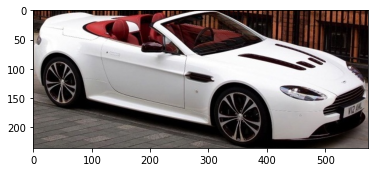

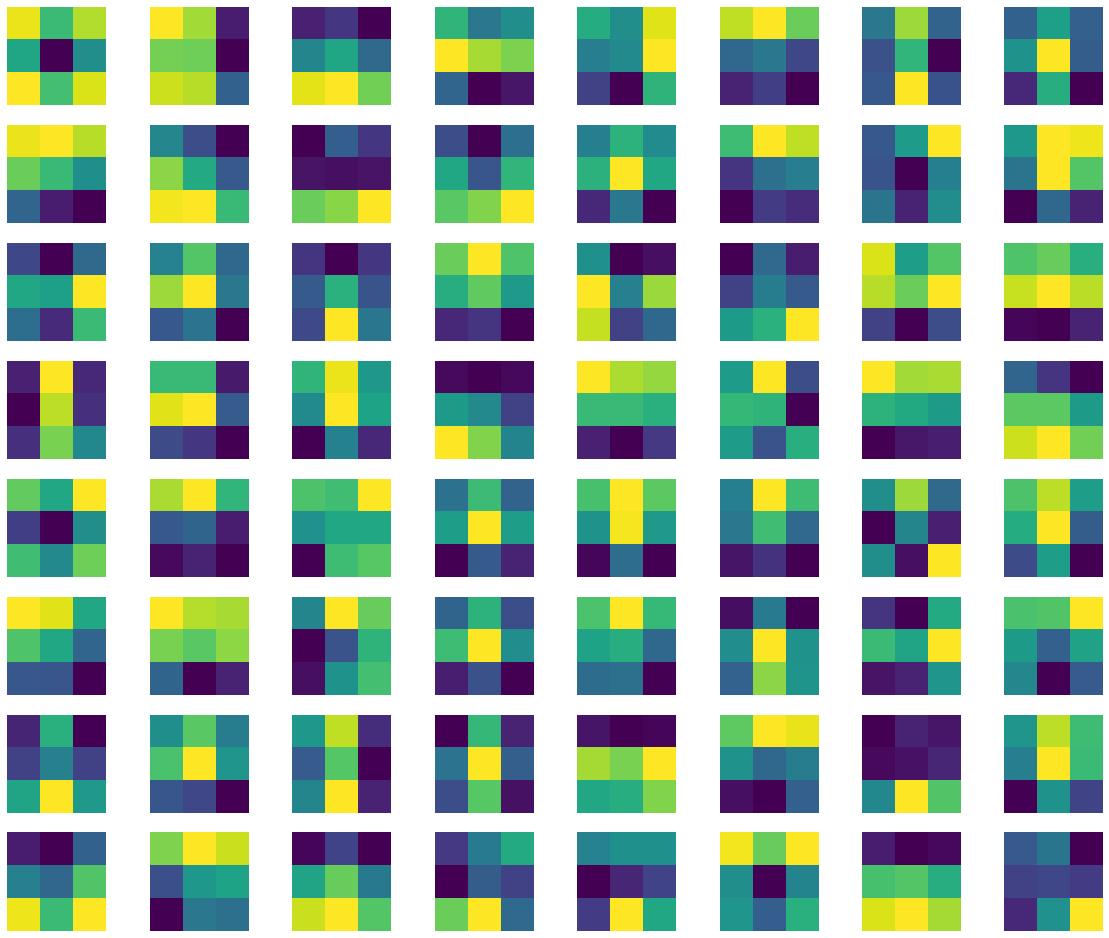

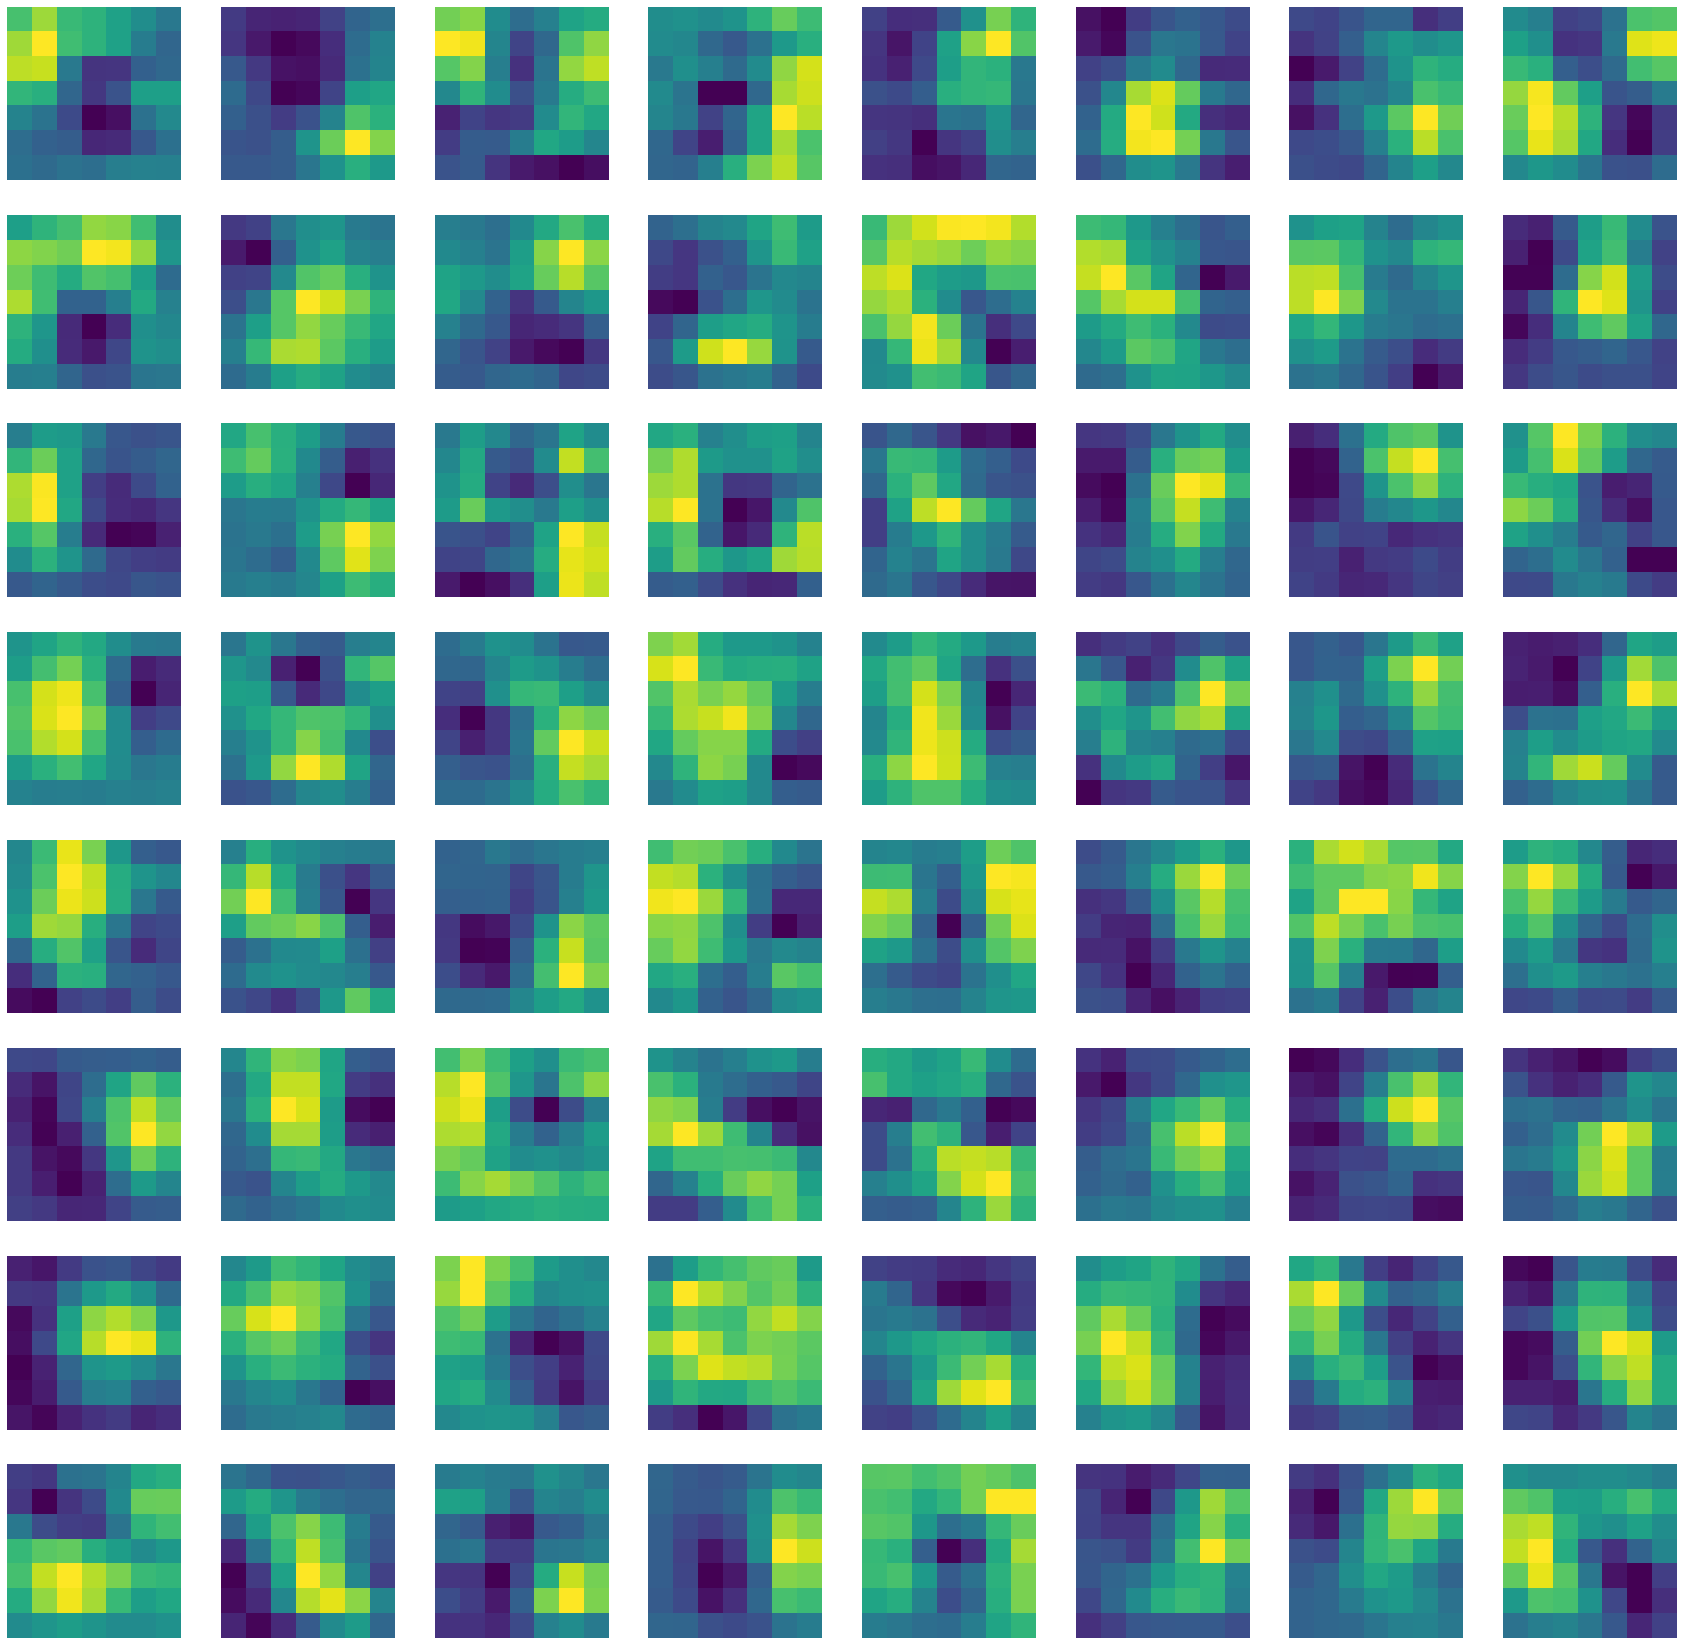

In [10]:
parser = argparse.ArgumentParser(description='Feature visualizations')

parser.add_argument('--path', default=None, required=True,
                    help='path to model to be tested')
parser.add_argument('-i', '--image', required=True, help='path to image')
parser.add_argument('--layer-num', required=True, type=int, help='layer to visualize')

args = parser.parse_args(args=['--path', model_path, '--image', image_path, '--layer-num', '32'])

main(args)